In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import scipy.io
import os
from urllib.request import urlopen
from urllib.error import HTTPError, URLError

In [2]:
def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print ("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print ("Done.")

    #handle errors
    except HTTPError:
        print ("HTTP Error:", url)
    except URLError:
        print ("URL Error:", url)

url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print ("Data file %s exists." % data_filename)

# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = scipy.io.loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Done.


In [3]:
img_size = (28,20)
img_data = scipy.io.loadmat('frey_rawface.mat')["ff"]
img_data = img_data.T.reshape((-1, img_size[0], img_size[1]))
trainX = torch.tensor(img_data[:int(0.8*img_data.shape[0])], dtype = torch.float)/255.

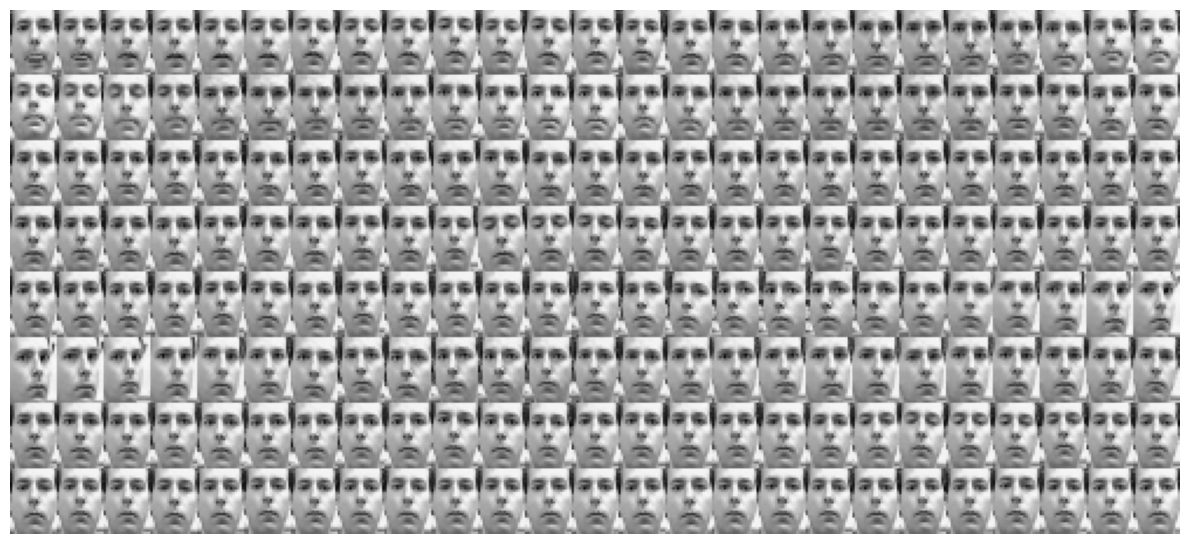

In [4]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())

    plt.figure(figsize=(12, 10))
    plt.imshow(figure, cmap = 'gray')
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=200, n_cols=25)


In [5]:
def get_minibatch(batch_size, device = 'cpu'):
  indices = torch.randperm(trainX.shape[0])[:batch_size]
  return trainX[indices].reshape(batch_size, -1).to(device)

In [6]:
class Model(nn.Module):
  def __init__(self, data_dim = 2, context_dim = 2, hidden_dim = 200, constrain_mean = False):
    super(Model, self).__init__()
    '''

    We model p(y|x) as N(mu, sigma) ; a normal distribution ; where mu and sigma are neural networks
    '''

    self.h = nn.Sequential(nn.Linear(context_dim, hidden_dim), nn.Tanh())
    self.log_var = nn.Sequential(nn.Linear(hidden_dim, data_dim))

    if constrain_mean:
      self.mu = nn.Sequential(nn.Linear(hidden_dim, data_dim), nn.Sigmoid())
    else:
      self.mu = nn.Sequential(nn.Linear(hidden_dim, data_dim))

  def get_mean_and_log_var(self,x) :
    h = self.h(x)
    mu = self.mu(h)
    log_var = self.log_var(h)
    return mu , log_var

  def forward(self, epsilon, x) :
    '''
    Sample y ~ p(y|x) using the reparametrization trick
    '''

    mu, log_var = self.get_mean_and_log_var(x)
    sigma = torch.sqrt(torch.exp(log_var))
    return epsilon*sigma + mu

  def compute_log_density(self, y, x) :
    '''
    Compute log p(y|x)
    '''

    mu, log_var = self.get_mean_and_log_var(x)
    log_density = -0.5*(torch.log(2*torch.tensor(np.pi)) + log_var + (((y-mu)**2)/(torch.exp(log_var) + 1e-10))).sum(dim=1)
    return log_density

  def compute_KL(self,x) :
    '''
    Assume that p(x) is a normal Gaussian distribution
    '''

    mu, log_var = self.get_mean_and_log_var(x)
    return -0.5*(1+log_var - mu**2 - torch.exp(log_var)).sum(dim=1)

In [7]:
  def AVEB(encoder, decoder, encoder_optimizer, decoder_optimizer, nb_epochs, M = 100, L = 1, latent_dim = 2):
      losses = []
      for epoch in tqdm(range(nb_epochs)) :
        x = get_minibatch(M, device = 'cpu')
        epsilon = torch.normal(torch.zeros(M*L, latent_dim), torch.ones(latent_dim)).to('cpu')

        # Now we compute the loss
        z = encoder(epsilon, x)
        log_likelihoods = decoder.compute_log_density(x,z)
        kl_divergence = encoder.compute_KL(x)
        loss = (kl_divergence - log_likelihoods.view(-1,L).mean(dim=1)).mean()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        losses.append(loss.item())
      return losses



In [8]:
device = 'cpu'
encoder = Model(data_dim = 2, context_dim = img_size[0]*img_size[1], hidden_dim = 200).to(device)
decoder = Model(data_dim = img_size[0]*img_size[1], context_dim = 2, hidden_dim = 200, constrain_mean = True).to(device)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.01, weight_decay = 0.5)
decoder_optimizer = torch.optim.Adam(decoder.parameters() ,lr = 0.01)

In [9]:
loss = AVEB(encoder, decoder, encoder_optimizer, decoder_optimizer, 10**5)

100%|██████████| 100000/100000 [23:51<00:00, 69.86it/s]


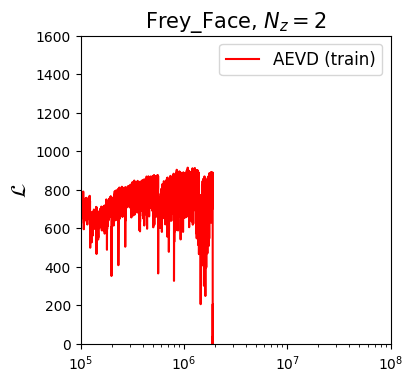

In [10]:
plt.figure(figsize = (4,4))
plt.plot(100*np.arange(len(loss)), -np.array(loss), c = 'r', label = 'AEVD (train)')
plt.xscale('log')
plt.xlim([10**5, 10**8])
plt.ylim(0,1600)
plt.title(r'Frey_Face, $N_z = 2$', fontsize = 15)
plt.ylabel(r'$\mathcal{L}$', fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig('Training_Loss.png', bbox_inches = "tight")
plt.show()

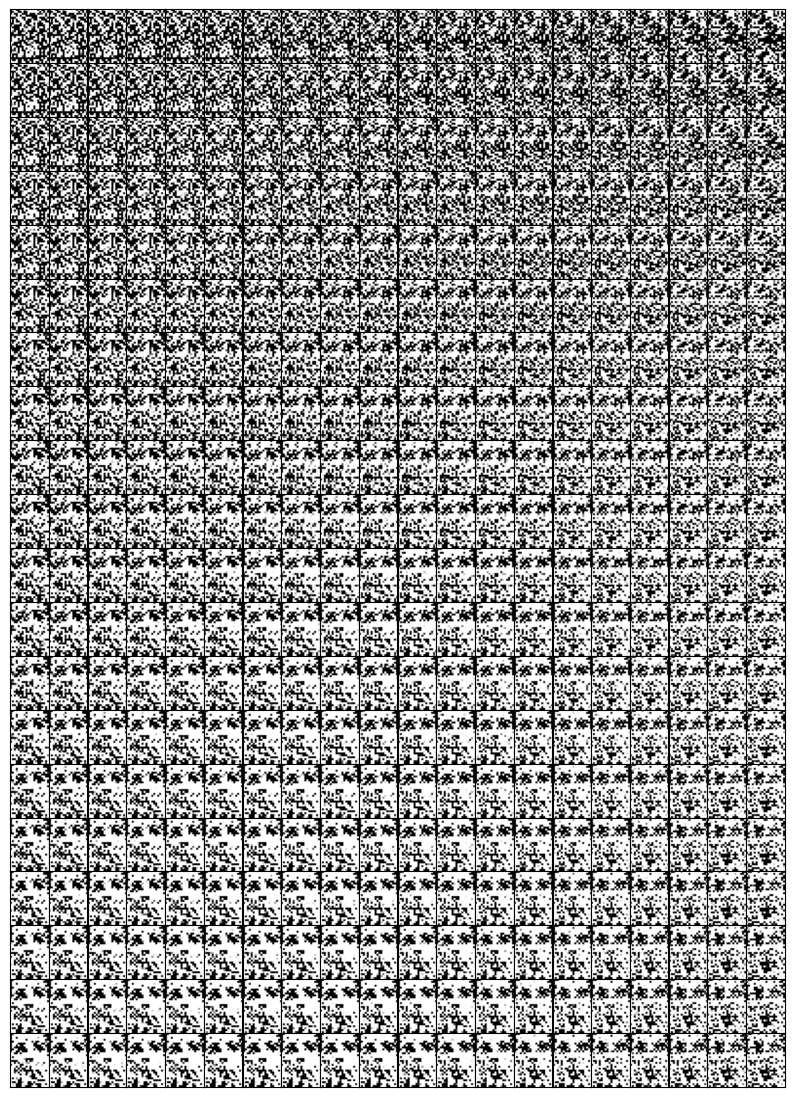

In [11]:
grid_size = 20
xx, yy = norm.ppf(np.meshgrid(np.linspace(0.1, 0.9, grid_size), np.linspace(0.1,0.9, grid_size)))

fig = plt.figure(figsize = (10,14), constrained_layout = False)
grid = fig.add_gridspec(grid_size, grid_size, wspace = 0, hspace = 0)

for i in range(grid_size):
  for j in range(grid_size):
    # Create a tensor with two elements for the coordinates
    coordinates = torch.tensor([xx[i, j], yy[i, j]], dtype=torch.float)
    img = decoder.get_mean_and_log_var(coordinates)
    ax = fig.add_subplot(grid[i,j])
    ax.imshow(np.clip(img[0].data.cpu().numpy().reshape(img_size[0], img_size[1]), 0, 1), cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('Learned_Data_Manifold.png', bbox_inches = "tight")
plt.show()